In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
from typing import Tuple
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Generating training data

The images used for training are captured with special cameras that can capture full-color information for every pixel.
These images are then processed to make them appear as if they were captured with a consumer camera, i.e. the information that would be filtered by the color filter array (CFA) is artificially removed.

The image below shows the bayer pattern, the most common CFA used today.

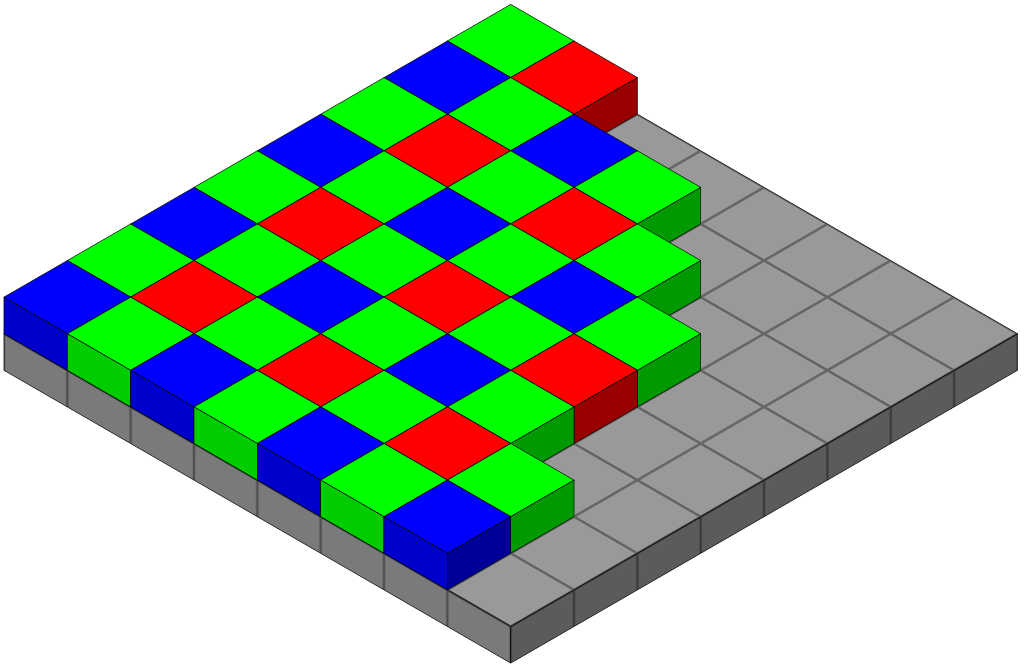

The information in the training images will be removed according to the bayer pattern. The network will try to restore the missing/removed information.

## Baseline

The color-peak-signal-to-noise-ratio (CPSNR), which is basically the logarithm of the MSE, is used as a quality metric.

The baseline is a CPSNR of `32.5 dB` (higher is better), which is achieved by applying bilinear interpolation separately to each color channel.
This result was obtained in Gharbi et al. (2016) [Deep Joint Demosaicking and Denoising](https://groups.csail.mit.edu/graphics/demosaicnet/data/demosaic.pdf).

## 1st Attempt

My first intention was to create `n x n` sized image patches which are then filtered with the bayer array, meaning that the inputs for the CNN are `n x n` sized patches wich have all been filtered using the exact same filter (e.g. top left corner green ...).
I thought this would make learning the "regressor" easier. On the other hand this means, that for building a fully working solution multiple CNNs with different bayer pattern offsets would have to be trained and applied accordingly during inference.

In [4]:
def calc_bayer_value(x: int, y: int, x_off: int = 0, y_off: int = 0):
  id = (x+y+x_off+y_off) % 2
  id += id*((y+y_off) % 2)
  id = (id+1) % 3
  return id

def calc_bayer_factors_3x3(x: int, y: int, x_off: int = 0, y_off: int = 0):
  f = np.zeros((3, 3, 3), dtype = np.float32)
  for dy in range(3):
    for dx in range(3):
      id = calc_bayer_value(x+dx, y+dy, x_off, y_off)
      f[dy, dx, id] = 1.0
  return f

def generate_bayer(width: int, height: int, offset_x: int, offset_y: int):
  result = []
  for x in range(width):
    row = []
    for y in range(height):
      id = calc_bayer_value(x, y, offset_x, offset_y)
      row.append(id)
    result.append(row)
  return np.array(result)

def generate_square_bayer(size: int, offset_x: int=0, offset_y: int=0):
  return generate_bayer(size, size, offset_x, offset_y)

def generate_bayer_3D(width: int, height: int, offset_x: int, offset_y: int):
  b = np.zeros((height, width, 3))
  for y in range(height):
    for x in range(width):
      b[y, x, calc_bayer_value(x, y, offset_x, offset_y)] = 1.0
  return b

def generate_square_bayer_3D(size: int, offset_x: int=0, offset_y: int=0):
  return generate_bayer_3D(size, size, offset_x, offset_y)

In [5]:
bayer_patch_size = 9
bayer_pattern = generate_square_bayer_3D(bayer_patch_size)
print(bayer_pattern[:,:,0])
print(bayer_pattern[:,:,1])
print(bayer_pattern[:,:,2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]]
[[0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]]


In [6]:
def load_img(filename: str, size: Tuple[int, int] = None, offset: Tuple[int, int] = None):
  img = np.array(Image.open(filename))

  if size is not None and offset is not None:
    return (
      img[offset[0]:(offset[0]+size[0]),
          offset[1]:(offset[1]+size[1]),
          :]
    )
  if size is not None:
    return (
      img[0:size[0],
          0:size[1],
          :]
    )
  return img

def file_to_image_patches(img: np.ndarray, stride: int, input_data_in = [], output_data_in = []):
  """loads training images and generates equally sized patches to serve as training input"""
  input_data = input_data_in.copy()
  output_data = output_data_in.copy()

  for y in range(0, img.shape[0], stride):
    for x in range(0, img.shape[1], stride):
      patch = img[y:(y+bayer_patch_size), x:(x+bayer_patch_size), :]
      
      if (patch.shape[0] != bayer_patch_size or
          patch.shape[1] != bayer_patch_size):
        continue
      patch = patch / 255.0
      # # append output (prenoise)
      output = patch[bayer_patch_size//2, bayer_patch_size//2]
      output_data.append(output)
      # # add noise
      # patch = patch + np.random.normal(0.0, 0.03, size=patch.shape)
      filtered = patch * bayer_pattern
      input_data.append(filtered)
      
  return input_data, output_data

In [11]:
train_files_path = './input_data/'
train_filenames = os.listdir(train_files_path)
train_filenames = list(filter(lambda str: not str.startswith('.'), train_filenames))
input_data = []
output_data = []
for filename in tqdm(train_filenames):
  img = load_img(os.path.join(train_files_path, filename))
  input_data, output_data = file_to_image_patches(
                              img,
                              2,
                              input_data,
                              output_data)

input_data = np.array(input_data)
output_data = np.array(output_data)
# print(input_data.shape)
# print(output_data.shape)

100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


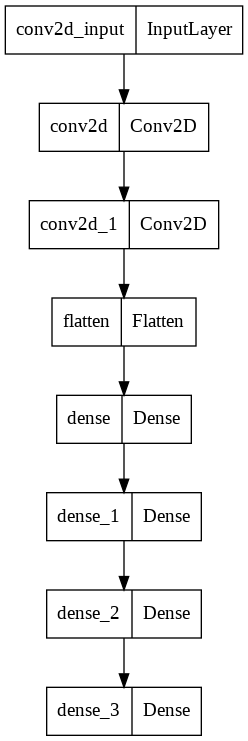

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=48*2, kernel_size=(5, 5), strides=(2, 2), input_shape=(9,9,3)), # activation='leaky_relu'), # 9x9 -> 3x3
    tf.keras.layers.Conv2D(filters=48*3, kernel_size=(3, 3)), # 3x3 -> 1x1
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2*16*3, activation='leaky_relu'),
    tf.keras.layers.Dense(16*3, activation='leaky_relu'),
    tf.keras.layers.Dense(9, activation='leaky_relu'),
    tf.keras.layers.Dense(3, activation=None)
], name='demosaic')

tf.keras.utils.plot_model(model)

In [ ]:
print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit(input_data, output_data, epochs=8, batch_size=1024, validation_split=0.1)

Model: "demosaic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 3, 96)          7296      
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 144)         124560    
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 96)                13920     
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                                 
 dense_2 (Dense)             (None, 9)                 441       
                                                                 
 dense_3 (Dense)             (None, 3)                 30 

In [ ]:
model.save('cnn_v3.h5')

In [34]:
model = tf.keras.models.load_model('cnn_v3.h5')

In [12]:
def save_img(data, filename):
  pred_byte = data*255.0
  pred_byte = np.clip(pred_byte, 0.0, 255.0)
  pred_byte = pred_byte.astype(np.uint8)
  s_img = Image.fromarray(pred_byte, mode='RGB')
  s_img.save(filename)

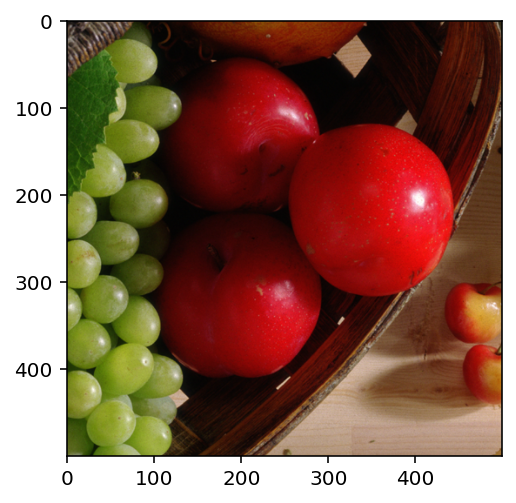

In [13]:
plt.rcParams['figure.dpi'] = 144
img = load_img(os.path.join('test_data', '15.tif'))
plt.imshow(img)
plt.show()

In [31]:
def reshape_prediction(pred, original_shape):
  h = original_shape[0] - (bayer_patch_size-1)
  w = original_shape[1] - (bayer_patch_size-1)
  pred = np.clip(pred, 0.0, 1.0)
  pred = np.reshape(pred, (h, w, 3))
  return pred

In [32]:
def CPSNR(x, y):
  diff = x - y
  square = diff*diff
  normed = np.mean(square) #sum / (x.shape[0] * x.shape[1] * 3)
  cpsnr = 10.0 * np.log10(1.0 / normed)
  return cpsnr

#### Evaluate on test images

In [35]:
path = 'test_data'
test_filenames = os.listdir(path)
test_filenames = list(filter(lambda str: not str.startswith('.'), test_filenames))
for file in test_filenames:
  img = load_img(os.path.join(path, file))
  # load
  test_input_data, test_output_data = file_to_image_patches(img, 1)
  test_input_data = np.array(test_input_data)
  test_output_data = np.array(test_output_data)
  # predict
  prediction = model.predict(test_input_data, batch_size=2048)
  rpred = reshape_prediction(prediction, img.shape)
  orig = reshape_prediction(test_output_data, img.shape)
  # eval
  cpsnr = CPSNR(rpred, orig)
  print(f'CPSNR({file}) = {cpsnr}')

119/119 [==============================] - 0s 3ms/step
CPSNR(6.tif) = 37.38789090760414
119/119 [==============================] - 0s 3ms/step
CPSNR(18.tif) = 37.60244588846012
119/119 [==============================] - 0s 3ms/step
CPSNR(15.tif) = 39.48311544780141


##### Original Image

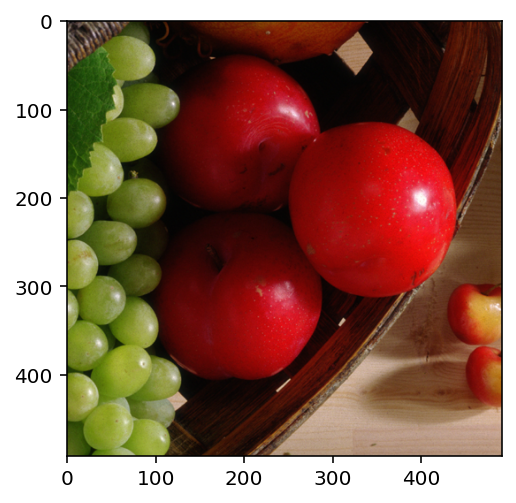

In [24]:
plt.imshow(orig)
plt.show()

##### Input Image (filtered)

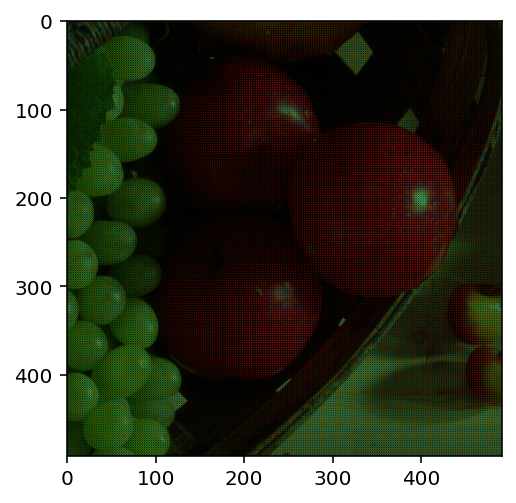

In [23]:
cfa = generate_square_bayer_3D(orig.shape[0])
camera_raw = cfa * orig
plt.imshow(camera_raw)
plt.show()

##### Predicted Image

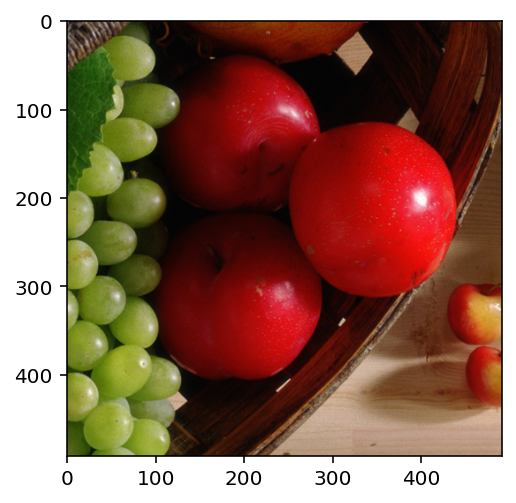

In [22]:
plt.imshow(rpred)
plt.show()

##### Conclusion

Quality is quite good, but as mentioned above, its a bit of a cheat, because this method cannot be applied on the whole mosaic "as is", because it assumes that the input is a `9 x 9` patch and the bayer filter is exactly the same for all patches.

## 2nd Attempt

To get rid of the shortcoming listed above, I used a "FCNN" architecture.
The CNN does not make any assumptions about the offset of the bayer filter for its current patch, which means it has to "learn" how deal with all possible cases (e.g. `[g,r,g,...]`, `[r,g,r,...]`, etc.).

> NOTE: The training data now consists of whole images and not small patches.

In [36]:
train_files_path = './input_data/'
train_filenames = os.listdir(train_files_path)
train_filenames = list(filter(lambda str: not str.startswith('.'), train_filenames))
input_data = []
output_data = []
for filename in tqdm(train_filenames):
  img = (load_img(os.path.join(train_files_path, filename)) / 255.0)
  height, width, _ = img.shape
  bayer = generate_bayer_3D(width, height, 0, 0)
  filtered = img * bayer
  input_data.append(filtered)
  output_data.append(img[3:-3, 3:-3, :])

input_data = np.array(input_data)
output_data = np.array(output_data)

100%|██████████| 15/15 [00:02<00:00,  7.48it/s]


In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=48*2, kernel_size=(5, 5), input_shape=(None, None, 3)),
    tf.keras.layers.Conv2D(filters=48*3, kernel_size=(3, 3)),  #          ^because 'width'/'height' can vary for Conv2D
    tf.keras.layers.Conv2D(filters=2*16*3, kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=16*3,   kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=9,      kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=3,      kernel_size=(1, 1), activation=None)
], name='demosaic')

In [ ]:
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

hist = model.fit(input_data, output_data, epochs=24, batch_size=2, validation_split=0.1)

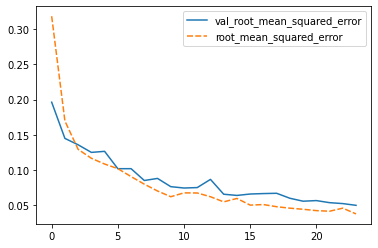

In [ ]:
hist = {key:hist.history[key] for key in ['val_root_mean_squared_error', 'root_mean_squared_error']}
sns.lineplot(data=hist)

In [ ]:
model.save('fcnn_v3.h5')

In [37]:
model = tf.keras.models.load_model('fcnn_v3.h5')

#### Evaluate on test images

1/1 [==============================] - 0s 56ms/step


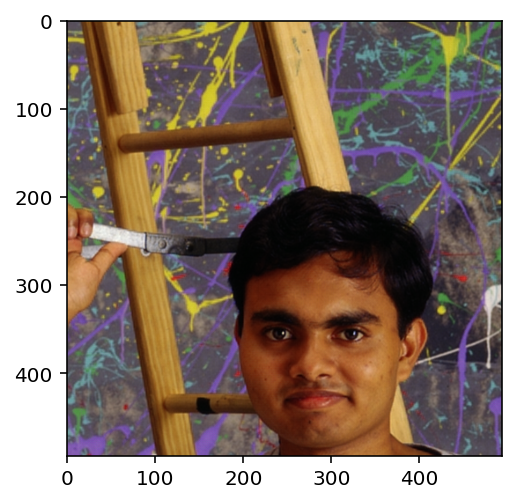

CPSNR(6.tif) = 34.48240812022828
1/1 [==============================] - 0s 22ms/step


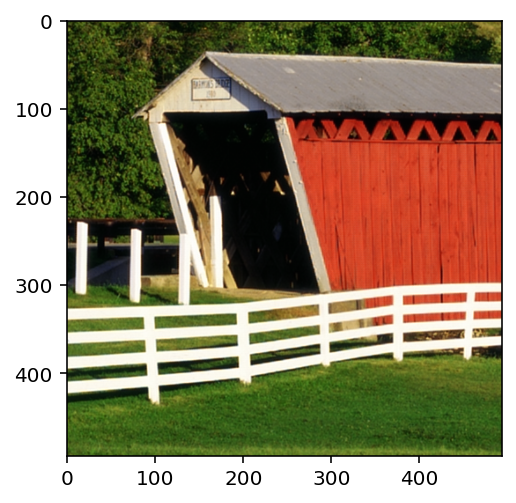

CPSNR(18.tif) = 32.76896221771602
1/1 [==============================] - 0s 20ms/step


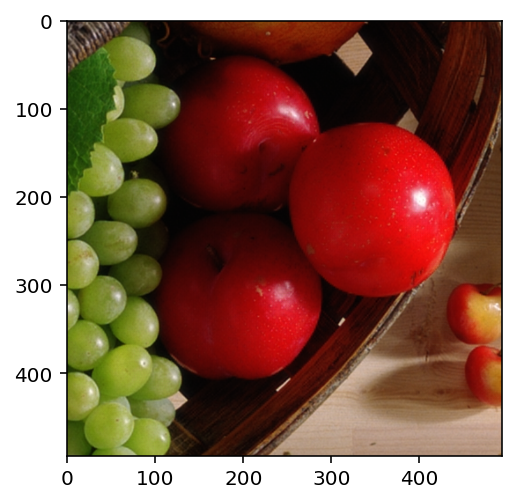

CPSNR(15.tif) = 37.46757468174798


In [38]:
plt.rcParams['figure.dpi'] = 144
path = 'test_data'
test_filenames = os.listdir(path)
test_filenames = list(filter(lambda str: not str.startswith('.'), test_filenames))
for file in test_filenames:
  img = load_img(os.path.join(path, file)) / 255.0
  bayer = generate_bayer_3D(width, height, 0, 0)
  # load
  test_input_data = np.array([ img*bayer ])
  test_output_data = np.array([ img ])[:, 3:-3, 3:-3, :]
  # predict
  prediction = model.predict(test_input_data, batch_size=1)

  

  plt.imshow(np.clip(
      np.reshape(prediction, newshape=prediction.shape[1:]),
      0.0,
      1.0))
  plt.show()
  
  # eval
  cpsnr = CPSNR(prediction, test_output_data)
  print(f'CPSNR({file}) = {cpsnr}')

##### Conclusion

The quality of the FCNN is "surprisingly" good, considering the rather small network and the low amount of training images.
State-of-the-art methods reach an average CPSNR of about `40dB`, but are trained on thousands or even millions of images.

## Experiment

##### 1) More layers/filter-stages, but smaller (initial) kernel size.

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=48*2, kernel_size=(3, 3), input_shape=(None, None, 3)),
    tf.keras.layers.Conv2D(filters=48*2, kernel_size=(3, 3)),  #          ^because 'width'/'height' can vary for Conv2D
    tf.keras.layers.Conv2D(filters=48*2, kernel_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=48*2, kernel_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=2*16*3, kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=16*3,   kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=9,      kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=3,      kernel_size=(1, 1), activation=None)
], name='demosaic')

In [44]:
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

hist = model.fit(input_data, output_data[:, 1:-1, 1:-1, :], epochs=24, batch_size=2, validation_split=0.1)

Model: "demosaic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, None, None, 96)    2688      
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 96)    83040     
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 96)    83040     
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 96)    83040     
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 96)    9312      
                                                                 
 conv2d_18 (Conv2D)          (None, None, None, 48)    4656      
                                                                 
 conv2d_19 (Conv2D)          (None, None, None, 9)     441

In [47]:
path = 'test_data'
test_filenames = os.listdir(path)
test_filenames = list(filter(lambda str: not str.startswith('.'), test_filenames))
for file in test_filenames:
  img = load_img(os.path.join(path, file)) / 255.0
  bayer = generate_bayer_3D(width, height, 0, 0)
  # load
  test_input_data = np.array([ img*bayer ])
  test_output_data = np.array([ img ])[:, 4:-4, 4:-4, :]
  # predict
  prediction = model.predict(test_input_data, batch_size=1)
  # eval
  cpsnr = CPSNR(prediction, test_output_data)
  print(f'CPSNR({file}) = {cpsnr}')

1/1 [==============================] - 0s 24ms/step
CPSNR(6.tif) = 33.04952615978615
1/1 [==============================] - 0s 15ms/step
CPSNR(18.tif) = 30.651391136750526
1/1 [==============================] - 0s 18ms/step
CPSNR(15.tif) = 34.970137448766074


##### 2) Single convolutional layer/filter-stage, but larger (initial) kernel size.

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=48*3, kernel_size=(7, 7), input_shape=(None, None, 3)),
    tf.keras.layers.Conv2D(filters=2*16*3, kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=16*3,   kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=9,      kernel_size=(1, 1), activation='leaky_relu'),
    tf.keras.layers.Conv2D(filters=3,      kernel_size=(1, 1), activation=None)
], name='demosaic')

In [53]:
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

hist = model.fit(input_data, output_data, epochs=24, batch_size=2, validation_split=0.1)

Model: "demosaic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, None, None, 144)   21312     
                                                                 
 conv2d_27 (Conv2D)          (None, None, None, 96)    13920     
                                                                 
 conv2d_28 (Conv2D)          (None, None, None, 48)    4656      
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 9)     441       
                                                                 
 conv2d_30 (Conv2D)          (None, None, None, 3)     30        
                                                                 
Total params: 40,359
Trainable params: 40,359
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/24
7/7 [==============================] -

In [56]:
path = 'test_data'
test_filenames = os.listdir(path)
test_filenames = list(filter(lambda str: not str.startswith('.'), test_filenames))
for file in test_filenames:
  img = load_img(os.path.join(path, file)) / 255.0
  bayer = generate_bayer_3D(width, height, 0, 0)
  # load
  test_input_data = np.array([ img*bayer ])
  test_output_data = np.array([ img ])[:, 3:-3, 3:-3, :]
  # predict
  prediction = model.predict(test_input_data, batch_size=1)
  # eval
  cpsnr = CPSNR(prediction, test_output_data)
  print(f'CPSNR({file}) = {cpsnr}')

1/1 [==============================] - 0s 18ms/step
CPSNR(6.tif) = 31.240406333888924
1/1 [==============================] - 0s 16ms/step
CPSNR(18.tif) = 28.766203745122247
1/1 [==============================] - 0s 19ms/step
CPSNR(15.tif) = 34.049331311836724


##### Conclusion

For this special setup, the "deeper" and "narrower" network performed a bit better.
Of course a more sophisticated experiment would repeat the measurements multiple times and perform a hyperparameter optimization for example.